In [1]:
import sys
sys.path.append('../')

from utils.fit_ellipse import transform_tensor_batched, ellipse_params_batched, plot_batch_with_ellipses
from utils.utils_train import MultiEllipseLoss
from utils.utils_data import get_dataloader
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_path='/home/michaelbertagna/git/Galaxy-Deconv/simulated_datasets/LSST_23.5_deconv'
train_val_split=0.8
batch_size=2
train_loader, val_loader = get_dataloader(data_path=data_path, train=True, train_val_split=train_val_split, batch_size=batch_size)

tensor(66587.9297, grad_fn=<MeanBackward0>)


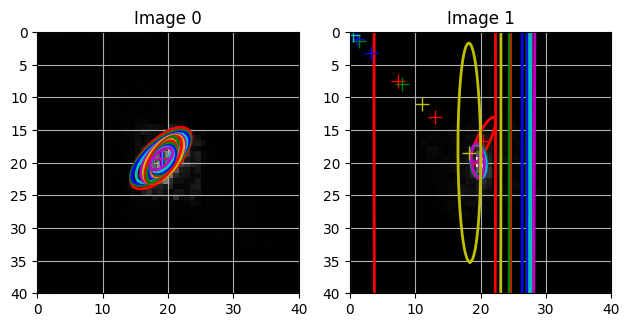

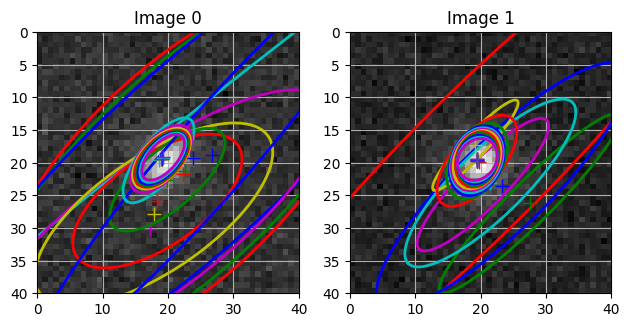

In [ ]:
import time
from IPython.display import clear_output
import numpy as np

step = 0.025
pps = np.arange(start=0.3, stop=0.7+step, step=step)
color_codes = ['r', 'g', 'b', 'c', 'm', 'y']

loss_fn = MultiEllipseLoss(
            ellipse_levels=pps,
            center_weight=1.0,
            angle_weight=1.0,
            axis_weight=1.0,
            ellipse_weights=None,
            loss_aggregation='mean'
        )

for idx, ((obs, psf, alpha), gt) in enumerate(train_loader):
    clear_output()
    params_sets_gt, mean_sam_dists_gt = zip(*[ellipse_params_batched(transform_tensor_batched(gt), peak_pos=pp) for pp in pps])
    params_sets_obs, mean_sam_dists_obs = zip(*[ellipse_params_batched(transform_tensor_batched(obs), peak_pos=pp) for pp in pps])
    print(loss_fn(gt, obs))
    # print([(pps[i], color_codes[i%len(color_codes)], mean_sam_dists_gt) for i in range(len(pps))])
    fig, axes = plot_batch_with_ellipses(gt, list(params_sets_gt), num_cols=2)
    plt.show()
    # print([(pps[i], color_codes[i%len(color_codes)], mean_sam_dists_obs) for i in range(len(pps))])
    fig, axes = plot_batch_with_ellipses(obs, list(params_sets_obs), num_cols=2)
    plt.show()
    # print([ellipse_loss_batched(o, g) for o, g in zip(params_sets_obs, params_sets_gt)])
    # print([ellipse_loss_batched(o, g) for o, g in zip(params_sets_gt, params_sets_obs)])
    # print([ellipse_loss_batched(o, g) for o, g in zip(params_sets_gt, params_sets_gt)])
    # print([ellipse_loss_batched(o, g) for o, g in zip(params_sets_obs, params_sets_obs)])
    time.sleep(3)